### Linear Regression Analysis of ADR
To find variables that affect the Average Daily Rate (ADR) which is derived by dividing the sum of all lodging transactions by the total number of staying nights

In [1]:
import pandas as pd
import numpy as np
import calendar
from datetime import datetime
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('hotel/hotel_bookings.csv')
data.head(1)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01


In [3]:
# remove all bookings that were cancelled. They generated no adr
data.drop(data[data['is_canceled'] == 1].index, inplace=True)
data['is_canceled'].unique()

array([0], dtype=int64)

In [4]:
# drop some irrelevant columns
hotel_data = data.drop(columns=['is_canceled','lead_time', 'arrival_date_week_number', 'country', 'market_segment',
                              'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'customer_type',
                              'previous_bookings_not_canceled', 'days_in_waiting_list'])

In [5]:
hotel_data.head()

,hotel,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,assigned_room_type,booking_changes,deposit_type,agent,company,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,2015,July,1,0,0,2,0.0,0,BB,...,C,3,No Deposit,NaN,NaN,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,2015,July,1,0,0,2,0.0,0,BB,...,C,4,No Deposit,NaN,NaN,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,2015,July,1,0,1,1,0.0,0,BB,...,C,0,No Deposit,NaN,NaN,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,2015,July,1,0,1,1,0.0,0,BB,...,A,0,No Deposit,304.0,NaN,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,2015,July,1,0,2,2,0.0,0,BB,...,A,0,No Deposit,240.0,NaN,98.0,0,1,Check-Out,2015-07-03


In [6]:
# convert month name of arrival date to number from full month name
arrival_date_month = []
for month in hotel_data['arrival_date_month']:
    month_num = list(calendar.month_name).index(month)
    arrival_date_month.append(month_num) 
hotel_data['arrival_date_month'] = arrival_date_month

# convert arrival_date_year to datetime datatype
hotel_data['arrival_date_year'] = hotel_data['arrival_date_year'].astype(str) + ('-') + hotel_data['arrival_date_month'].astype(str) + ('-') + hotel_data['arrival_date_day_of_month'].astype(str)
hotel_data['arrival_date_year'] = pd.to_datetime(hotel_data['arrival_date_year'])

# rename arrival date column
hotel_data.rename(columns = {'arrival_date_year' : 'arrival_date'}, inplace=True)
hotel_data = hotel_data.drop(columns=['arrival_date_month', 'arrival_date_day_of_month'])
hotel_data.head()

,hotel,arrival_date,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,2015-07-01,0,0,2,0.0,0,BB,C,C,3,No Deposit,NaN,NaN,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,2015-07-01,0,0,2,0.0,0,BB,C,C,4,No Deposit,NaN,NaN,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,2015-07-01,0,1,1,0.0,0,BB,A,C,0,No Deposit,NaN,NaN,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,2015-07-01,0,1,1,0.0,0,BB,A,A,0,No Deposit,304.0,NaN,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,2015-07-01,0,2,2,0.0,0,BB,A,A,0,No Deposit,240.0,NaN,98.0,0,1,Check-Out,2015-07-03


In [7]:
# convert categorical variable to binary
def cat_binary(col_name, value):
    bin_col = []
    for word in hotel_data[col_name]:
        if word == value:
            word = 0
        else:
            word = 1
        bin_col.append(word)
    return bin_col

In [8]:
# convert categorical variable (numeric) to binary
def to_binary(col_name):
    bin_col = []
    for val in hotel_data[col_name]:
        if val > 0:
            val = 1
        else:
            val = 0
        bin_col.append(val)
        
    return bin_col  

In [9]:
# convert room type to binary
def col_binary(col1, col2):
    col_val = []
    for val1, val2 in zip(hotel_data[col1], hotel_data[col2]):
        if val1 == val2:
            val1 = 1
        else:
            val1 = 0
        col_val.append(val1)  
    return col_val    

In [10]:
# convert hotel column to binary
hotel_data['hotel'] = cat_binary('hotel', 'Resort Hotel')
hotel_data.head()

,hotel,arrival_date,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,2015-07-01,0,0,2,0.0,0,BB,C,C,3,No Deposit,NaN,NaN,0.0,0,0,Check-Out,2015-07-01
1,0,2015-07-01,0,0,2,0.0,0,BB,C,C,4,No Deposit,NaN,NaN,0.0,0,0,Check-Out,2015-07-01
2,0,2015-07-01,0,1,1,0.0,0,BB,A,C,0,No Deposit,NaN,NaN,75.0,0,0,Check-Out,2015-07-02
3,0,2015-07-01,0,1,1,0.0,0,BB,A,A,0,No Deposit,304.0,NaN,75.0,0,0,Check-Out,2015-07-02
4,0,2015-07-01,0,2,2,0.0,0,BB,A,A,0,No Deposit,240.0,NaN,98.0,0,1,Check-Out,2015-07-03


In [11]:
# convert meal column to binary. undefined = 0, else=1
hotel_data['meal'] = cat_binary('meal', 'Undefined')
hotel_data.head()

,hotel,arrival_date,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,2015-07-01,0,0,2,0.0,0,1,C,C,3,No Deposit,NaN,NaN,0.0,0,0,Check-Out,2015-07-01
1,0,2015-07-01,0,0,2,0.0,0,1,C,C,4,No Deposit,NaN,NaN,0.0,0,0,Check-Out,2015-07-01
2,0,2015-07-01,0,1,1,0.0,0,1,A,C,0,No Deposit,NaN,NaN,75.0,0,0,Check-Out,2015-07-02
3,0,2015-07-01,0,1,1,0.0,0,1,A,A,0,No Deposit,304.0,NaN,75.0,0,0,Check-Out,2015-07-02
4,0,2015-07-01,0,2,2,0.0,0,1,A,A,0,No Deposit,240.0,NaN,98.0,0,1,Check-Out,2015-07-03


In [12]:
# convert room type to binary and rename the column
hotel_data['reserved_room_type'] = col_binary('reserved_room_type', 'assigned_room_type')
hotel_data.rename(columns = {'reserved_room_type': 'reserved_room'}, inplace=True)
hotel_data = hotel_data.drop('assigned_room_type', axis=1)
hotel_data.head()

,hotel,arrival_date,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,reserved_room,booking_changes,deposit_type,agent,company,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,2015-07-01,0,0,2,0.0,0,1,1,3,No Deposit,NaN,NaN,0.0,0,0,Check-Out,2015-07-01
1,0,2015-07-01,0,0,2,0.0,0,1,1,4,No Deposit,NaN,NaN,0.0,0,0,Check-Out,2015-07-01
2,0,2015-07-01,0,1,1,0.0,0,1,0,0,No Deposit,NaN,NaN,75.0,0,0,Check-Out,2015-07-02
3,0,2015-07-01,0,1,1,0.0,0,1,1,0,No Deposit,304.0,NaN,75.0,0,0,Check-Out,2015-07-02
4,0,2015-07-01,0,2,2,0.0,0,1,1,0,No Deposit,240.0,NaN,98.0,0,1,Check-Out,2015-07-03


In [13]:
# convert deposit type to binary. No deposit=0, else=1
hotel_data['deposit_type'] = cat_binary('deposit_type', 'No Deposit')

# convert agent and company to binary
hotel_data['agent'] = to_binary('agent')
hotel_data['company'] = to_binary('company')
hotel_data.head()

,hotel,arrival_date,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,reserved_room,booking_changes,deposit_type,agent,company,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,2015-07-01,0,0,2,0.0,0,1,1,3,0,0,0,0.0,0,0,Check-Out,2015-07-01
1,0,2015-07-01,0,0,2,0.0,0,1,1,4,0,0,0,0.0,0,0,Check-Out,2015-07-01
2,0,2015-07-01,0,1,1,0.0,0,1,0,0,0,0,0,75.0,0,0,Check-Out,2015-07-02
3,0,2015-07-01,0,1,1,0.0,0,1,1,0,0,1,0,75.0,0,0,Check-Out,2015-07-02
4,0,2015-07-01,0,2,2,0.0,0,1,1,0,0,1,0,98.0,0,1,Check-Out,2015-07-03


In [14]:
# convert processed data to csv
hotel_data.to_csv('hotel_data.csv', index=False)

In [15]:
# check linear correlation in quantitative variables (does not include binary)
quantitative_var = hotel_data[['stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies',
                             'booking_changes','adr', 'required_car_parking_spaces', 'total_of_special_requests']]
quantitative_var.corr()

,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,booking_changes,adr,required_car_parking_spaces,total_of_special_requests
stays_in_weekend_nights,1.000000,0.510640,0.129297,0.018588,0.015573,0.071874,0.037395,-0.024422,0.064120
stays_in_week_nights,0.510640,1.000000,0.133444,0.013600,0.016333,0.117565,0.050289,-0.025504,0.059289
adults,0.129297,0.133444,1.000000,0.043202,0.028784,-0.069437,0.334175,0.038672,0.204176
children,0.018588,0.013600,0.043202,1.000000,0.025052,0.047858,0.319919,0.075011,0.094490
babies,0.015573,0.016333,0.028784,0.025052,1.000000,0.079817,0.034152,0.034384,0.094595
booking_changes,0.071874,0.117565,-0.069437,0.047858,0.079817,1.000000,0.013968,0.042575,-0.003353
adr,0.037395,0.050289,0.334175,0.319919,0.034152,0.013968,1.000000,0.087010,0.220595
required_car_parking_spaces,-0.024422,-0.025504,0.038672,0.075011,0.034384,0.042575,0.087010,1.000000,0.044902
total_of_special_requests,0.064120,0.059289,0.204176,0.094490,0.094595,-0.003353,0.220595,0.044902,1.000000


`stays_in_weekend_nights` and `stays_in_week_nights` are correlated. Since OLS assumes that none of the independent variables are correlated, we should combine them into a dummy variable called `overnight`.  This will be done in another notebook. Meanwhile, we will check if we can find a relationship between `adr` and the other variables.

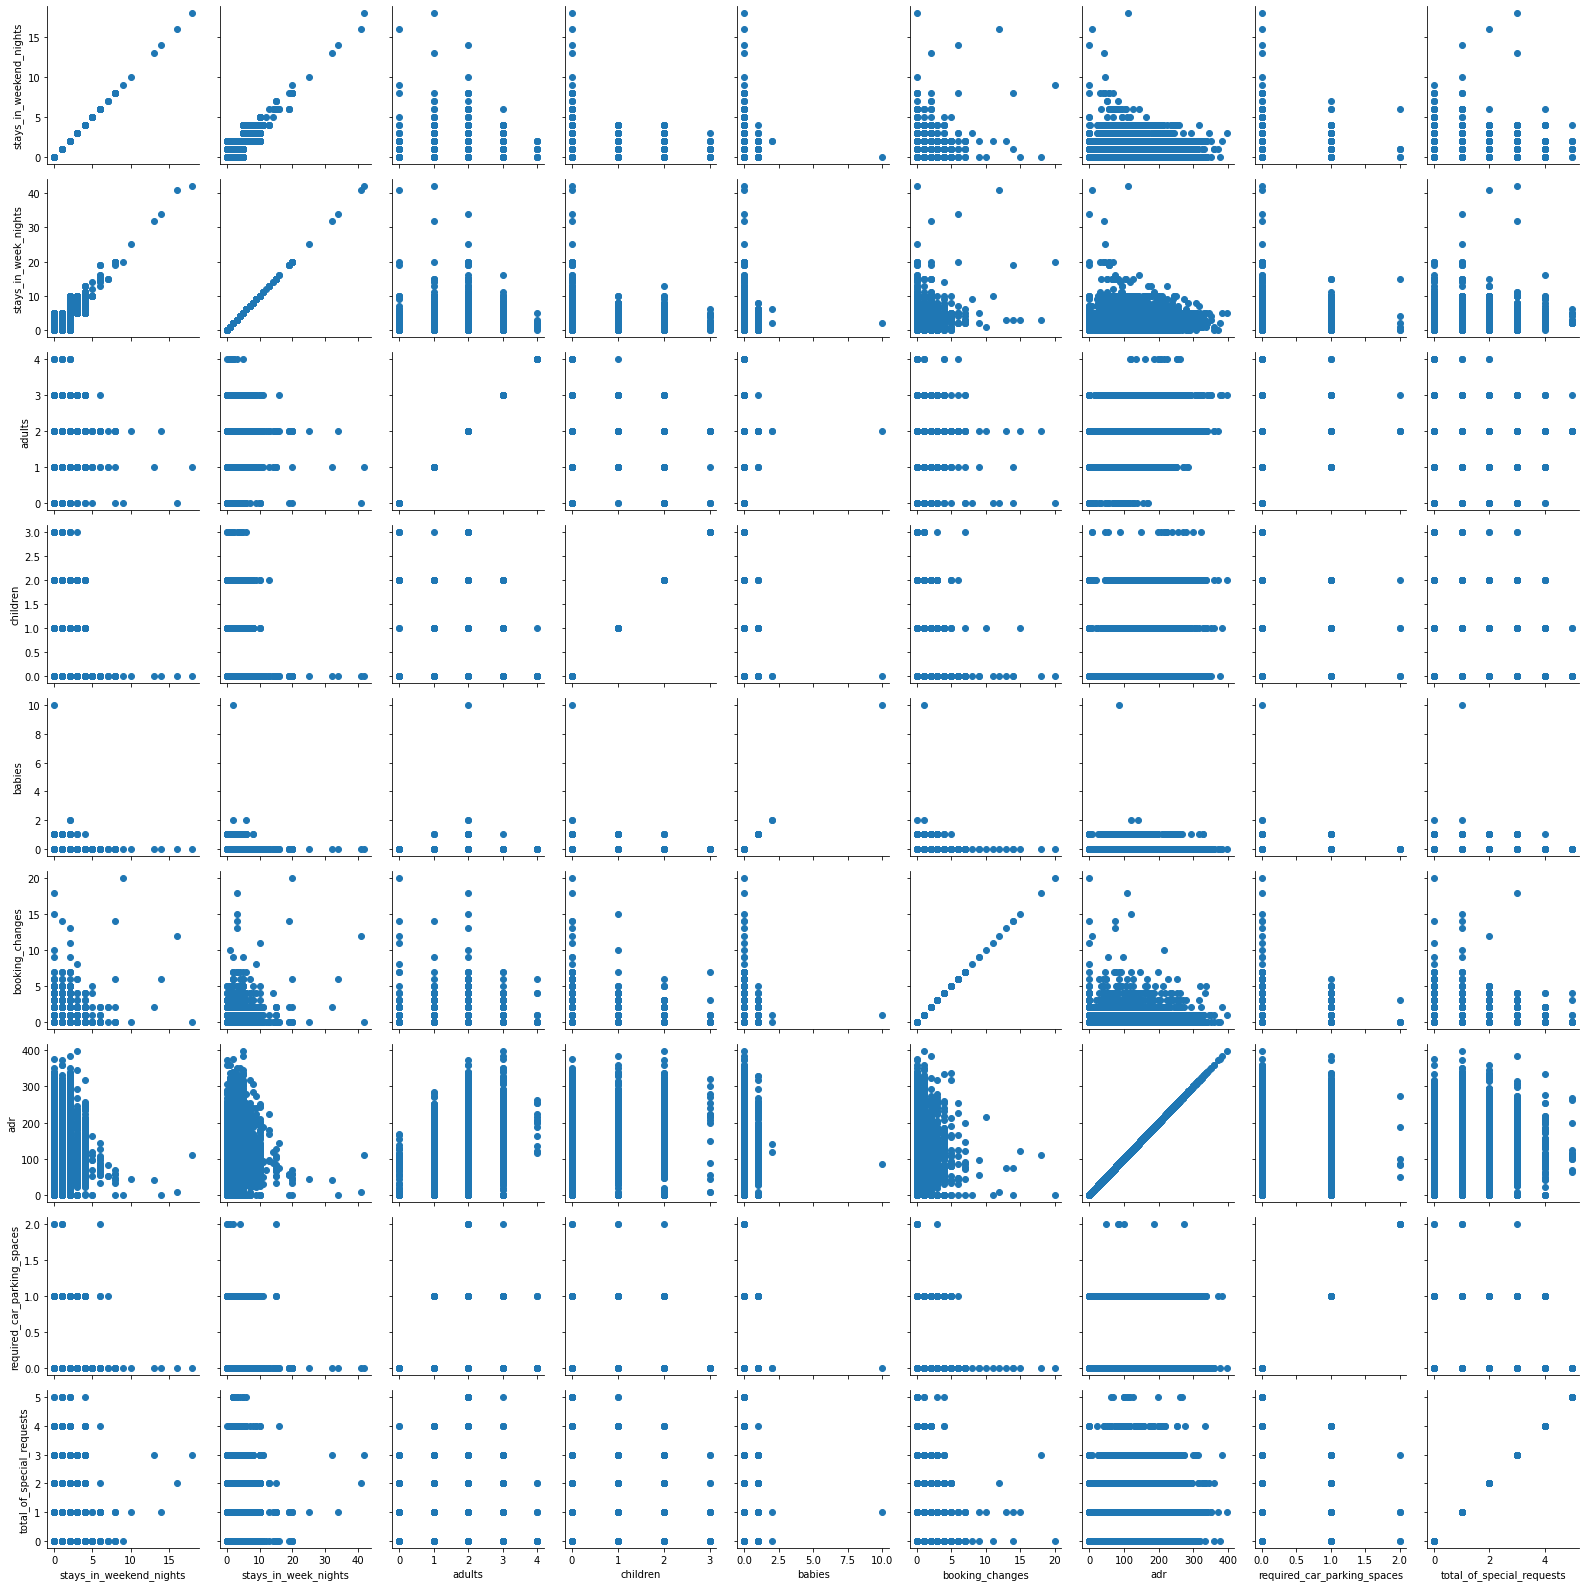

In [16]:
# check for linearity with a scatter plot
sample_data = hotel_data.sample(20000)
qty_vars = ['stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies',
                             'booking_changes','adr', 'required_car_parking_spaces', 'total_of_special_requests']
fig = sns.PairGrid(data=sample_data, vars=qty_vars)
fig.map(plt.scatter)
plt.show()

The graphs do not show any interesting pattern.

In [17]:
# define independent and dependent variables
y = hotel_data['adr']
x1 = hotel_data.drop(['reservation_status','reservation_status_date','arrival_date','adr'], axis=1)
x = sm.add_constant(x1)

In [18]:
# model 1 - all data columns except dates
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    adr   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     1990.
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:52:39   Log-Likelihood:            -3.8765e+05
No. Observations:               75166   AIC:                         7.753e+05
Df Residuals:                   75151   BIC:                         7.755e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          29.3991      1.606     18.309      0.000      26.252      32.546
hotel                          15.8157      0.349     45.365      0.000      15.132      16.499
stays_in_weekend_nights        -0.9560      0.182     -5.263      0.000      -1.312      -0.600
stays_in_week_nights            0.6921      0.096      7.222      0.000       0.504       0.880
adults                         25.8563      0.324     79.911      0.000      25.222      26.491
children                       35.8168      0.396     90.413      0.000      35.040      36.593
babies                          3.7453      1.369      2.736      0.006       1.062       6.429
meal                           -9.9395      1.443     -6.886      0.000     -12.769      -7.110
reserved_room                  14.0583      0.403     34.887      0.000      13.268      14.848
booking_changes                 2.1620      0.213     10.157      0.000       1.745       2.579
deposit_type                   -3.8886      2.864     -1.358      0.175      -9.502       1.725
agent                           1.7558      0.542      3.241      0.001       0.694       2.818
company                       -11.6911      0.760    -15.384      0.000     -13.181     -10.202
required_car_parking_spaces    15.2611      0.528     28.909      0.000      14.226      16.296
total_of_special_requests       6.5812      0.191     34.382      0.000       6.206       6.956
==============================================================================
Omnibus:                    12876.830   Durbin-Watson:                   0.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34510.990
Skew:                           0.935   Prob(JB):                         0.00
Kurtosis:                       5.743   Cond. No.                         77.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model 1 has a low R-squared indicating that the  variability in y is not well explained by x. The P-values are all less than 0.05 so the coefficents are signifcantly different from zero

In [19]:
# model 2 - only quantitative data excluding binary data
x2 = hotel_data[['stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies',
                             'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests']]
x = sm.add_constant(x2)

results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    adr   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     2724.
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:52:39   Log-Likelihood:            -3.8993e+05
No. Observations:               75166   AIC:                         7.799e+05
Df Residuals:                   75157   BIC:                         7.800e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          37.8033      0.609     62.049      0.000      36.609      38.997
stays_in_weekend_nights        -0.9320      0.186     -5.020      0.000      -1.296      -0.568
stays_in_week_nights            0.1939      0.096      2.013      0.044       0.005       0.383
adults                         28.5050      0.321     88.800      0.000      27.876      29.134
children                       36.5730      0.408     89.687      0.000      35.774      37.372
babies                          1.2957      1.410      0.919      0.358      -1.468       4.059
booking_changes                 1.2880      0.218      5.903      0.000       0.860       1.716
required_car_parking_spaces     7.5801      0.524     14.454      0.000       6.552       8.608
total_of_special_requests       7.7427      0.195     39.633      0.000       7.360       8.126
==============================================================================
Omnibus:                     8099.486   Durbin-Watson:                   0.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17602.865
Skew:                           0.673   Prob(JB):                         0.00
Kurtosis:                       4.951   Cond. No.                         34.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model 2 has an even lower R-squared indicating that the variability in the y is not well explained by x. The P-values are all less than 0.05 except for `babies` so the coefficents are signifcantly different from zero